In [16]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rotation_tools import RotationSimulation, RotationalState
from scipy.spatial.transform import Rotation as R
import pickle
plt.rcParams.update({'font.family': 'serif', 'font.size': 12, 'mathtext.fontset': 'cm'})

In [2]:
true_P = 21.28
e_period = 2022.5 # secular oscillation period in units where hyperion's orbital period is 2pi

N = 100
P = 2*np.pi
ts = np.arange(0, N*P, P/100)
t_offset = {'cas1':0,'cas2':67,'cas3':107, 'cascorr1':0,'cascorr2':67,'cascorr3':107}

all_obs = {}
fid_sim = {}
M = {}
harb_rot = R.from_euler('ZXZ', [40, 20, 10], degrees=True)
id_rot = R.from_euler('ZXZ', [0, 0, 0], degrees=True)

black_theta0 = 0.5776584
black_phi0 = 2.3123878
black_psi0 = 2.2597257
black_thetadot0 = 3.5542896
black_phidot0 = -3.3128323
black_psidot0 = 2.3196794
black_omegaa0 = black_thetadot0*np.sin(black_phi0)*np.sin(black_psi0) + black_phidot0*np.cos(black_psi0)
black_omegab0 = black_thetadot0*np.sin(black_phi0)*np.cos(black_psi0) - black_phidot0*np.sin(black_psi0)
black_omegac0 = black_thetadot0*np.cos(black_phi0) + black_psidot0

all_inits = {'black':{'e':0.1236, 'M0':np.radians(20.0065), 'theta0':0.5776584, 'phi0':2.3123878, 'psi0':2.2597257, 'omega0':3.5542896, 'omegaa0':black_omegaa0, 'omegab0':black_omegab0, 'omegac0':black_omegac0, 'A':0.3234, 'B':0.4597, 'C':0.5192, 'princip_ax_rot':id_rot},
 'cas1':{'e':0.115, 'M0':np.radians(295), 'theta0':0.004, 'phi0':1.441, 'psi0':0.427, 'omega0':4.433, 'omegaa0':4.433*0.890, 'omegab0':4.433*0.067, 'omegac0':4.433*0.451, 'A':0.314, 'B':0.474, 'C':0.542, 'princip_ax_rot':id_rot},
 'cas2':{'e':0.115, 'M0':np.radians(342), 'theta0':1.885, 'phi0':2.118, 'psi0':1.180, 'omega0':4.255, 'omegaa0':4.255*0.907, 'omegab0':4.255*0.162, 'omegac0':4.255*0.389, 'A':0.314, 'B':0.474, 'C':0.542, 'princip_ax_rot':id_rot},
 'cas3':{'e':0.113, 'M0':np.radians(303), 'theta0':2.989, 'phi0':1.685, 'psi0':1.641, 'omega0':4.255, 'omegaa0':4.255*0.902, 'omegab0':4.255*0.133, 'omegac0':4.255*0.411, 'A':0.314, 'B':0.474, 'C':0.542, 'princip_ax_rot':id_rot},
 'cascorr1':{'e':0.115, 'M0':np.radians(295), 'theta0':0.004, 'phi0':1.441, 'psi0':0.427, 'omega0':4.433, 'omegaa0':4.433*0.890, 'omegab0':4.433*0.067, 'omegac0':4.433*0.451, 'A':0.314, 'B':0.474, 'C':0.542, 'princip_ax_rot':harb_rot},
 'cascorr2':{'e':0.115, 'M0':np.radians(342), 'theta0':1.885, 'phi0':2.118, 'psi0':1.180, 'omega0':4.255, 'omegaa0':4.255*0.907, 'omegab0':4.255*0.162, 'omegac0':4.255*0.389, 'A':0.314, 'B':0.474, 'C':0.542, 'princip_ax_rot':harb_rot},
 'cascorr3':{'e':0.113, 'M0':np.radians(303), 'theta0':2.989, 'phi0':1.685, 'psi0':1.641, 'omega0':4.255, 'omegaa0':4.255*0.902, 'omegab0':4.255*0.133, 'omegac0':4.255*0.411, 'A':0.314, 'B':0.474, 'C':0.542, 'princip_ax_rot':harb_rot}}

for name, inits in all_inits.items():
    body_rot = R.from_euler('ZXZ', [inits['theta0'], inits['phi0'], inits['psi0']], degrees=False)
    omegaa0, omegab0, omegac0 = (body_rot.inv() * inits['princip_ax_rot'].inv() * body_rot).inv().apply([inits['omegaa0'], inits['omegab0'], inits['omegac0']])
    theta0, phi0, psi0 = (inits['princip_ax_rot'].inv() * body_rot).as_euler('ZXZ')
    all_obs[name] = RotationalState([theta0, phi0, psi0, omegaa0, omegab0, omegac0], A=inits['A'], B=inits['B'], C=inits['C'])
    fid_sim[name] = RotationSimulation(A=inits['A'], B=inits['B'], C=inits['C'], e_forced=inits['e'], e_free=0.0, e_period=e_period, n=1.0, M0=inits['M0'])
    fid_sim[name].integrate(ts, all_obs[name])
    M[name] = fid_sim[name].sol.t + inits['M0']

In [8]:
permute_axes= [[0, 1, 0], [0, 0, 1], [1, 0, 0]]
andoyer = {name: sim.sol.andoyer(permute_axes=permute_axes) for name, sim in fid_sim.items()}
G = {name: a[0] for name, a in andoyer.items()}
Lambda = {name: a[1] for name, a in andoyer.items()}
L = {name: a[2] for name, a in andoyer.items()}
g = {name: a[3] for name, a in andoyer.items()}
lambda_node = {name: a[4] for name, a in andoyer.items()}
l = {name: a[5] for name, a in andoyer.items()}

In [9]:
p = Path('integration_outputs')
ham_model = {'cas1': np.loadtxt(p / 'obs1.csv', delimiter=','), 'cas2':np.loadtxt(p / 'obs2.csv', delimiter=','), 'cas3':np.loadtxt(p / 'obs3.csv', delimiter=','), 
             'cascorr1':np.loadtxt(p / 'obscorr1.csv', delimiter=','), 'cascorr2':np.loadtxt(p / 'obscorr2.csv', delimiter=','), 'cascorr3':np.loadtxt(p / 'obscorr3.csv', delimiter=','),
             'black':np.loadtxt(p / 'obsblack.csv', delimiter=',')}

In [18]:
sims = pickle.load(open('/mnt/data-big/mgoldberg/satellites/hyperion_rotation/sols_1.0_new_fast.p', 'rb'))
print([(sim.e_forced, sim.e_free) for sim in sims])
def get_sim(e_config):
    # for sim in sims:
    #     if (sim.e_forced, sim.e_free) == e_config:
    #         return sim
    # return None
    return [sim for sim in sims if (sim.e_forced, sim.e_free) == e_config]
sims[0].sol.quat[0].shape

[(0.01, 0.0), (0.0158, 0.0), (0.0251, 0.0), (0.0398, 0.0), (0.0631, 0.0), (0.01, 0.0), (0.0158, 0.0), (0.0251, 0.0), (0.0398, 0.0), (0.0631, 0.0), (0.01, 0.0), (0.0158, 0.0), (0.0251, 0.0), (0.0398, 0.0), (0.0631, 0.0), (0.1, 0.0), (0.158, 0.0), (0.251, 0.0), (0.398, 0.0), (0.631, 0.0), (0.1, 0.0), (0.158, 0.0), (0.251, 0.0), (0.398, 0.0), (0.631, 0.0), (0.1, 0.0), (0.158, 0.0), (0.251, 0.0), (0.398, 0.0), (0.631, 0.0)]


(7,)

In [19]:
e_config = (0.1, 0.0)
sim = get_sim(e_config)[2]
G_long, Lambda_long, L_long, g_long, lambda_node_long, l_long = sim.sol.andoyer(permute_axes=permute_axes)

/home/mgoldberg/miniconda3/envs/nbody/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  exec(code_obj, self.user_global_ns, self.user_ns)


/tmp/ipykernel_1166353/4287442759.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,1].set_xticklabels(['0', '10', '20', '30', '40'])


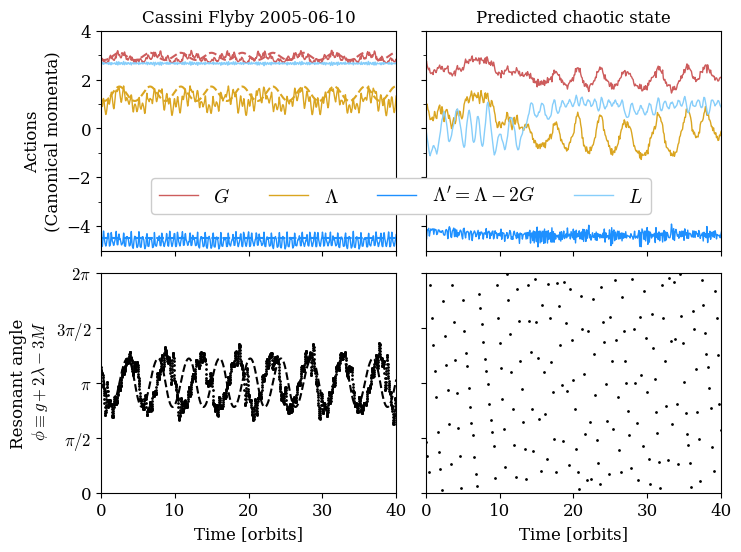

In [46]:
thinning = 2
colors = {'G':'indianred', 'Lambda':'goldenrod', 'Lambda - 2G':'dodgerblue', 'L':'lightskyblue'}
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex='col', sharey='row', gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
for i,i_obs in enumerate(['cascorr1']):
    label = '' if i_obs == 'cascorr1' else '_'
    A = (fid_sim[i_obs].B + fid_sim[i_obs].C)/2
    axs[0,i].plot(fid_sim[i_obs].sol.t/(2*np.pi), G[i_obs]/A, label=label + '$G$', lw=1, c=colors['G'])
    axs[0,i].plot(fid_sim[i_obs].sol.t/(2*np.pi), Lambda[i_obs]/A, label=label + '$\Lambda$', lw=1, c=colors['Lambda'])
    axs[0,i].plot(fid_sim[i_obs].sol.t/(2*np.pi), Lambda[i_obs]/A - 2*G[i_obs]/A, label=label + "$\Lambda'=\Lambda - 2G$", lw=1, c=colors['Lambda - 2G'])
    axs[0,i].plot(fid_sim[i_obs].sol.t/(2*np.pi), L[i_obs]/A, label=label + '$L$', lw=1, c=colors['L'])
    axs[0,i].axhline(andoyer[i_obs][1,0]/A - 2*andoyer[i_obs][0,0]/A, linestyle='--', color=colors['Lambda - 2G'])
    axs[0,i].plot(ham_model[i_obs][:,0]/(2*np.pi), ham_model[i_obs][:,1]/A, label='', linestyle='--', color=colors['G'])
    axs[0,i].plot(ham_model[i_obs][:,0]/(2*np.pi), ham_model[i_obs][:,2]/A, label='', linestyle='--', color=colors['Lambda'])
    axs[1,i].scatter(fid_sim[i_obs].sol.t[::thinning]/(2*np.pi), np.remainder(g[i_obs] + 2*lambda_node[i_obs] - 3*M[i_obs], 2*np.pi)[::thinning], label='_$g + 2\lambda - 3M$', s=1, c='k')
    res_angle = np.remainder(ham_model[i_obs][:,3] - 3*(ham_model[i_obs][:,0] + M[i_obs][0]), 2*np.pi)
    idx_to_skip = np.append([0], np.where(np.abs(np.diff(res_angle)) > 1)[0])
    res_angle[idx_to_skip] = np.nan
    axs[1,i].plot(ham_model[i_obs][:,0]/(2*np.pi), res_angle, label='_$g$', linestyle='--', color='k')
    
A = (sim.B + sim.C)/2
axs[0,1].plot(sim.sol.t/(2*np.pi), G_long/A, lw=1, c=colors['G'])
axs[0,1].plot(sim.sol.t/(2*np.pi), Lambda_long/A, lw=1, c=colors['Lambda'])
axs[0,1].plot(sim.sol.t/(2*np.pi), Lambda_long/A - 2*G_long/A, lw=1, c=colors['Lambda - 2G'])
axs[0,1].plot(sim.sol.t/(2*np.pi), L_long/A, lw=1, c=colors['L'])
axs[1,1].scatter(sim.sol.t[::thinning]/(2*np.pi), np.remainder(g_long + 2*lambda_node_long - 3*(sim.M0+sim.sol.t), 2*np.pi)[::thinning], s=1, c='k')

axs[1,0].set_xlabel('Time [orbits]')
axs[1,1].set_xlabel('Time [orbits]')

axs[0,0].set_xlim(0, 40)
axs[1,0].set_xlim(0, 40)
axs[0,1].set_xlim(4000, 4040)
axs[1,1].set_xlim(4000, 4040)

axs[1,0].set_ylim(0, 2*np.pi)
axs[0,0].set_ylim(-5, 4)

fig.legend(loc='upper center', ncols=4, fontsize=14, bbox_to_anchor=(0.5, 0.65), framealpha=1)
axs[1,0].set_ylabel('Resonant angle\n $\phi\equiv g + 2\lambda - 3M$')
axs[0,0].set_ylabel('Actions\n(Canonical momenta)')
axs[0,0].set_yticks([-4, -2, 0, 2, 4])
axs[0,0].set_yticks([-3, -1, 1, 3], minor=True)
axs[1,0].set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
axs[0,0].set_title('Cassini Flyby 2005-06-10', fontsize=12)
axs[0,1].set_title('Predicted chaotic state', fontsize=12)
axs[1,0].set_yticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
axs[0,1].set_xticklabels(['0', '10', '20', '30', '40'])
plt.savefig('../figs/hyperion_application.pdf', bbox_inches='tight')

In [24]:
sim.M0

5.1487212933832724